┌───┐          ┌─┐      
q0_0: |0>┤ H ├──■───────┤M├──────
         └───┘┌─┴─┐     └╥┘┌─┐   
q0_1: |0>─────┤ X ├──■───╫─┤M├───
              └───┘┌─┴─┐ ║ └╥┘┌─┐
q0_2: |0>──────────┤ X ├─╫──╫─┤M├
                   └───┘ ║  ║ └╥┘
 c0_0: 0 ════════════════╩══╬══╬═
                            ║  ║ 
 c0_1: 0 ═══════════════════╩══╬═
                               ║ 
 c0_2: 0 ══════════════════════╩═
                                 
<class 'qiskit.ignis.mitigation.measurement.filters.TensoredFilter'>
[array([[0.727 , 0.2106, 0.2156, 0.0612, 0.2002, 0.0576, 0.0568, 0.0142],
       [0.0806, 0.5988, 0.0196, 0.169 , 0.0224, 0.174 , 0.0058, 0.05  ],
       [0.0812, 0.025 , 0.6016, 0.1676, 0.0218, 0.0042, 0.1758, 0.0424],
       [0.0098, 0.0668, 0.0628, 0.4996, 0.0018, 0.0204, 0.0188, 0.1406],
       [0.0822, 0.0256, 0.0226, 0.0072, 0.6212, 0.1606, 0.1602, 0.0448],
       [0.0094, 0.0646, 0.0028, 0.0216, 0.0676, 0.5096, 0.0174, 0.143 ],
       [0.0084, 0.0018, 0.0676, 0.0182, 0.0558, 0.017 , 0.5

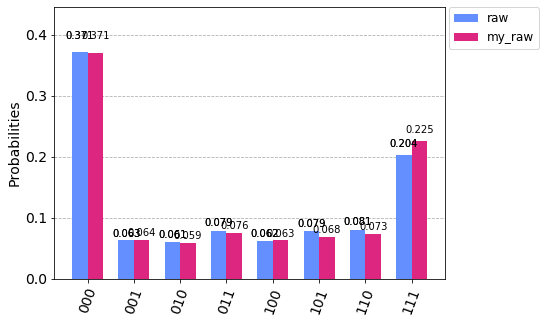

In [1]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,CompleteMeasFitter, TensoredMeasFitter)
from qiskit.compiler import transpile, assemble
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.extensions.standard import HGate, SGate, SdgGate, XGate, RXGate, RYGate, RZGate
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import noise
from utils.helper_fun import generate_circ, get_evaluator_info, reverseBits
from utils.mitigation import TensoredMitigation
from utils.submission import Scheduler
import copy
import math

# Make a 3Q GHZ state
full_circ_size = 3
qr = QuantumRegister(full_circ_size)
cr = ClassicalRegister(full_circ_size)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[0])
ghz.cx(qr[0], qr[1])
ghz.cx(qr[1], qr[2])
ghz.measure(qr,cr)
print(ghz)

# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

backend = Aer.get_backend('qasm_simulator')
job = execute([ghz], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

# Results without mitigation
raw_counts = results.get_counts()

# Generate the calibration circuits
mit_pattern = [range(full_circ_size)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
# Execute the calibration circuits
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=5000, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

# Get the filter object
meas_filter = meas_fitter.filter
print(type(meas_filter))
print(meas_fitter.cal_matrices)

# Results with mitigation
mitigated_results = meas_filter.apply(results,method='pseudo_inverse')
mitigated_counts = mitigated_results.get_counts(0)

device_name = 'ibmq_boeblingen'
circ_dict = {'test':{'circ':ghz,'shots':5000}}

tensored_mitigation = TensoredMitigation(circ_dict=circ_dict,device_name=device_name)
tensored_mitigation.run()

scheduler = Scheduler(circ_dict=circ_dict,device_name=device_name)
scheduler.run()

scheduler.retrieve()
tensored_mitigation.retrieve()
tensored_mitigation.apply(unmitigated=scheduler.circ_dict)
mitigated_circ_dict = tensored_mitigation.circ_dict
print(mitigated_circ_dict['test'].keys())
my_raw = mitigated_circ_dict['test']['hw']
my_mitigated = mitigated_circ_dict['test']['mitigated_hw']
my_raw_dict = {}
for i, p in enumerate(my_raw):
    bin_i = bin(i)[2:].zfill(full_circ_size)
    my_raw_dict[bin_i] = p
my_mitigated_dict = {}
for i, p in enumerate(my_mitigated):
    bin_i = bin(i)[2:].zfill(full_circ_size)
    my_mitigated_dict[bin_i] = p

plot_histogram([raw_counts, my_raw_dict], legend=['raw', 'my_raw'])

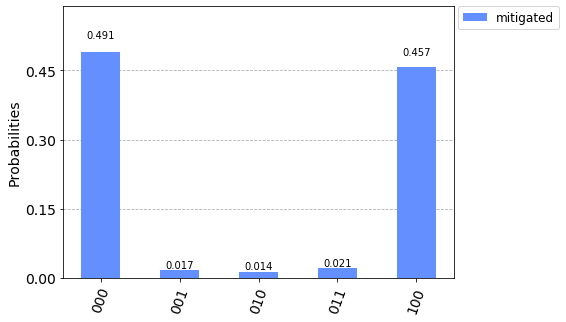

In [2]:
plot_histogram([mitigated_counts], legend=['mitigated'])

{'000': 0.48949072845281294, '001': 0.01340924305808315, '010': 0.0032093126682936415, '011': -0.017679544613509922, '100': 0.013661160857629993, '101': -0.03393863163855783, '110': -0.024461396929559592, '111': 0.556309128144808}


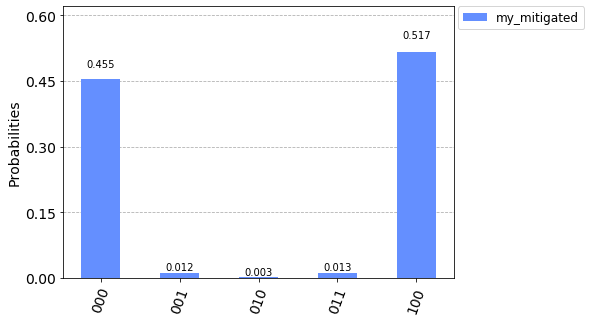

In [3]:
print(my_mitigated_dict)
plot_histogram([my_mitigated_dict], legend=['my_mitigated'])